In [1]:
from functions import *
from models import *

2024-11-06 17:26:32.813235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 17:26:32.833463: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 17:26:32.839678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 17:26:32.856233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 17:26:34.602874: W tensorflow/compiler/tf2

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import time
from datetime import datetime
from collections import Counter

## Load data

In [3]:
# Set variables
source_folder = '../data/external/raster_masks'
rivers = {}
source_path = '../data/preprocessed/'
data_paths = ['lst','wt_interpolated','ndvi','slope', 'discharge','altitude']#,'wt','ndvi','slope', 'discharge','masked']#,'slope', 'discharge']#, 'ndvi', 'wt', 'masked','discharge', 'slope']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k:[] for k in data_paths}    
total_data = {}
total_times = {}
complete_rivers = []
filter_river = None
W=256
time_split = True

# Load rivers
for subdir, dirs, files in os.walk(source_folder):
    for i,file in enumerate(files):
        r,m = load_raster(os.path.join(subdir, file), False)
        name = file.split('.')[0].split('bw_')[-1]
        rivers[name] = r

# Load input paths
for i,dir_p in enumerate(dir_paths):
    if data_paths[i] != 'discharge' and data_paths[i] != 'slope' and data_paths[i] != 'altitude':
        imgs_per_river = Counter()
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints'): 
            all_dir_paths[data_paths[i]].append(subdir)
        elif subdir.endswith('masked') and 'masked' in data_paths:
            all_dir_paths['masked'].append(subdir)
        elif dir_p.endswith('altitude'):
            all_dir_paths[data_paths[i]].extend(files)

In [4]:
# Load input data

for k,v in all_dir_paths.items():
    if filter_river != None:
        v = [v[i] for i in filter_river]
    
    if k != 'discharge' and k != 'slope' and k != 'altitude':
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)
            
        data, times = load_data(v,W,list_rgb)
        if k!='masked':
            labels = []
            for ki,value in data.items():
                labels+=[ki.split('/')[-1]]*len(value)
        
        data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
        times_list = [t for sublist in times for t in sublist]
   
        if time_split:
            dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
            pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
            sorted_dates, data_values, labels = zip(*pairs)
            times_list = [date.strftime('%Y-%m') for date in sorted_dates]
            
        total_data[k] = np.array(data_values)
        total_times[k] = times_list
        print(k,':' ,total_data[k].shape)

# Hot encoding
encoder = OneHotEncoder(sparse_output=False)
river_encoded = encoder.fit_transform(np.array(labels).reshape(-1, 1))
data_targets = total_data['wt_interpolated']
results = {'MAE':0,'MSE':0,'RMSE':0,'R²':0,'MAPE (%)':0,'MSE sample-wise':0}

lst : (147, 256, 256, 3)
wt_interpolated : (147, 256, 256)
ndvi : (147, 256, 256)


In [5]:
imgss = {}

for k,v in all_dir_paths.items():
    total = []
    if k == 'discharge' or k == 'slope' or k == 'altitude':
        for i,lab in enumerate(labels):
            for file in v:
                if lab == file.split('/')[-1] or lab == file.split('.')[0]:
                    if lab not in imgss.keys():
                        if k != 'altitude':
                            file_path = os.path.join(file,os.listdir(file)[0])
                        else:
                            file_path = os.path.join('../data/preprocessed/altitude', file)
                        
                        r,m = load_raster(file_path, False)
                        var = resize_image(r, W,W)
                        imgss[lab] = var
                    else:
                        var = imgss[lab]
                    total.append(var)
                        
        total_data[k] = np.array(total)
        print(k, np.array(total).shape)

slope (147, 256, 256)
discharge (147, 256, 256)
altitude (147, 256, 256)


#### Vectorize dates

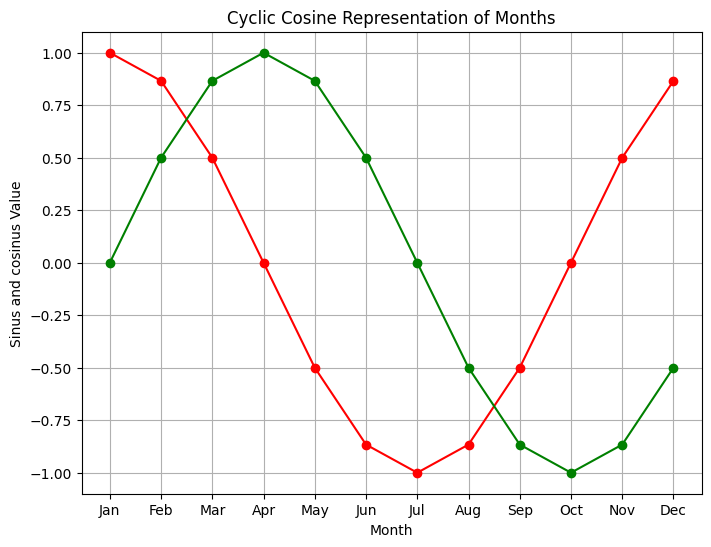

In [6]:
import numpy as np

# Create an empty dictionary to store the cosine values for each month
month_cosine_dict = {}
month_sinus_dict = {}

# Fill the dictionary with cosine values for each month
for month in range(1, 13):
    # Scale the month from 0 to 1 (January as 0, December as 11/12)
    month_scaled = (month - 1) / 12
    # Convert the scaled month to radians and apply the cosine function
    month_cosine = np.cos(month_scaled * 2 * np.pi)
    month_sinus = np.sin(month_scaled * 2 * np.pi)
    # Store it in the dictionary
    month_cosine_dict[month] = month_cosine
    month_sinus_dict[month] = month_sinus
   
months = list(month_cosine_dict.keys())
cosine_values = list(month_cosine_dict.values())
sinus_values = list(month_sinus_dict.values())
str_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(8, 6))
plt.plot(months, cosine_values, marker='o',color='red')
plt.plot(months, sinus_values, marker='o',color='green')
plt.xticks(months, str_months)
plt.xlabel('Month')
plt.ylabel('Sinus and cosinus Value')
plt.title('Cyclic Cosine Representation of Months')
plt.grid(True)
plt.show()


In [7]:
times_dt = pd.to_datetime(total_times['lst'])
cosine_months = []
sine_months = []
for time_dt in times_dt:
    m = time_dt.month
    cos = month_cosine_dict[m]
    sin = month_sinus_dict[m]
    cosine_months.append(cos)
    sine_months.append(sin)
    
cosine_months = np.array(cosine_months)
sine_months = np.array(sine_months)
print(len(cosine_months),len(sine_months))

147 147


## Do experiment

In [8]:
W = 256
filter_river = None#[3,11,12]
inputs = ['lst','ndvi','discharge', 'slope','altitude']#['ndvi','discharge', 'slope']
conditioned = True
batch_size = 16
epochs = 50
model_name = "img_wise_CNN" #img_wise_CNN, UNet, transfer_learning_VGG16, CNN, img_2_img
stratified = False
physics_guided = False

#### Choose model

In [9]:
def get_results(test_target, test_prediction, rivers, labels, test_index):
    mean_results = {k:[] for k in results.keys()}
    # Loop through each sample and compute the MSE for that sample
    for i in range(test_target.shape[0]):
        # Flatten the true and predicted values for this sample
        riv = rivers[labels[test_index[i]]].flatten()
        y_true_flatten = test_target[i].flatten()
        y_true_mask = y_true_flatten[riv != 0]
        y_pred_flatten = test_prediction[i].flatten()
        y_pred_mask = y_pred_flatten[riv != 0]
        # Calculate metrics
        res = evaluate_model(y_true_mask, y_pred_mask)
        for k,v in res.items():
            mean_results[k].append(v)
    for key in mean_results:
        mean_results[key] = np.mean(mean_results[key])
    return mean_results

In [10]:
# Choose inputs
inputs_d = [total_data[inp] for inp in inputs]
# List to store the processed additional images
expanded_images = []
# Expand dimensions for single-channel images, leave multi-channel images as they are
for img in inputs_d:
    if img.ndim == 3:  # Case where image is (n, 256, 256) (single-channel)
        expanded_images.append(np.expand_dims(img, axis=-1))  # Expand to add an extra channel
    elif img.ndim == 4:  # Case where image already has multiple channels (n, 256, 256, c)
        expanded_images.append(img)  # Leave the image as it is
# Concatenate all images along the last axis (channels)
combined_input = np.concatenate(expanded_images, axis=-1)
# The final combined input is stored in input_data
input_data = combined_input

### Split data

In [11]:
if time_split:
    train_ratio = 0.6
    val_ratio = 0.2
    test_ratio = 0.2
    
    # Calcular el tamaño de cada conjunto
    total_images = len(input_data)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)
    indices = np.arange(total_images)
    
    train_index = indices[:train_size]                       # Primeros índices para entrenamiento
    validation_index = indices[train_size:train_size + val_size]    # Siguientes índices para validación
    test_index = indices[train_size + val_size:]             # Últimos índices para prueba
   
elif stratified:
    train_index, validation_index, test_index = split_data_stratified(input_data, data_targets, labels)
else:
    train_index, validation_index, test_index = split_data(input_data, data_targets)
        
validation_input = input_data[validation_index, :] / 255.0  # Normalize inputs
validation_target = data_targets[validation_index, :]
validation_rivers = river_encoded[validation_index, :]
test_input = input_data[test_index, :] / 255.0  # Normalize inputs
test_target = data_targets[test_index, :]
test_rivers = river_encoded[test_index, :]
train_input = input_data[train_index, :] / 255.0  # Normalize inputs
train_target = data_targets[train_index, :]
train_rivers = river_encoded[train_index, :]

train_cos_months = cosine_months[train_index] 
train_sin_months = sine_months[train_index]

val_cos_months = cosine_months[validation_index]
val_sin_months = sine_months[validation_index]

test_cos_months = cosine_months[test_index]
test_sin_months = sine_months[test_index]

print(f"Train: {len(train_input)} imágenes, {train_input.shape}")
print(f"Val: {len(validation_input)} imágenes, {validation_input.shape}")
print(f"Test: {len(test_input)} imágenes, {test_input.shape}")
print(train_target.shape, validation_target.shape, test_target.shape)

train_dates = np.array(total_times['lst'])[train_index] 
validation_dates = np.array(total_times['lst'])[validation_index] 
test_dates = np.array(total_times['lst'])[test_index] 

Train: 88 imágenes, (88, 256, 256, 7)
Val: 29 imágenes, (29, 256, 256, 7)
Test: 30 imágenes, (30, 256, 256, 7)
(88, 256, 256) (29, 256, 256) (30, 256, 256)


In [12]:
print(train_dates)
print(validation_dates)
print(test_dates)

['2013-04' '2013-04' '2013-04' '2013-06' '2013-06' '2013-06' '2013-07'
 '2013-07' '2013-07' '2013-08' '2013-08' '2013-08' '2013-08' '2013-09'
 '2013-09' '2013-09' '2013-09' '2013-10' '2013-11' '2013-12' '2013-12'
 '2013-12' '2014-01' '2014-02' '2014-02' '2014-02' '2014-03' '2014-03'
 '2014-03' '2014-04' '2014-04' '2014-05' '2014-05' '2014-05' '2014-06'
 '2014-06' '2014-07' '2014-09' '2014-09' '2014-10' '2014-11' '2015-01'
 '2015-02' '2015-02' '2015-02' '2015-03' '2015-05' '2015-05' '2015-05'
 '2015-05' '2015-06' '2015-07' '2015-08' '2015-08' '2015-08' '2015-08'
 '2015-08' '2015-08' '2015-09' '2015-10' '2015-11' '2015-11' '2015-12'
 '2015-12' '2015-12' '2016-02' '2016-02' '2016-02' '2016-02' '2016-03'
 '2016-03' '2016-03' '2016-04' '2016-04' '2016-05' '2016-05' '2016-06'
 '2016-07' '2016-07' '2016-08' '2016-08' '2016-08' '2016-08' '2016-09'
 '2016-09' '2016-09' '2016-09' '2016-10']
['2016-11' '2016-11' '2016-12' '2016-12' '2016-12' '2016-12' '2017-01'
 '2017-03' '2017-03' '2017-03' '201

#### Select inputs and model

In [13]:
if len(train_input.shape) == 3:
    input_shape = train_input.shape[1:]+(1,)
else:
    input_shape = train_input.shape[1:]


# Adapt input to condition
if conditioned:
    input_args = (input_shape, river_encoded.shape[1])
    model_input = [train_input, train_rivers, train_cos_months, train_sin_months]
    val_model_input = [validation_input, validation_rivers, val_cos_months, val_sin_months]
    test_model_input = [test_input, test_rivers,  test_cos_months, test_sin_months]
else:
    input_args = input_shape
    model_input = train_input
    val_model_input = validation_input
    test_model_input = test_input
 
    

In [14]:
# Start model
start_time = time.time()
if model_name == "img_wise_CNN":
    if conditioned:
        #model = build_simplified_cnn_model_label(input_args[0], input_args[1])
        model = build_cnn_model_features(input_args[0], input_args[1])#, input_args[2], input_args[3])
    else:
        model = build_simplified_cnn_model(input_args)
elif model_name == 'CNN':
    if conditioned:
        model = build_cnn_model_label(input_args[0], input_args[1])
    else:
        model = build_cnn_model(input_args)
elif model_name == 'img_2_img':
    model = build_img_2_img_model(input_args)
elif model_name == 'UNet':
    model = build_unet(input_args)
elif model_name == 'transfer_learning_VGG16':
    train_input = train_input[:, :, :, :3]
    model = build_transfer_model((W, W, 3))
elif model_name == "img_wise_CNN_improved":
    model = build_simplified_cnn_model_improved(input_args)
        

2024-11-06 17:26:46.348311: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10530 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1
2024-11-06 17:26:46.349094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10532 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:81:00.0, compute capability: 6.1


### Train model

In [15]:
print(f"Running experiment with model={model_name}, batch_size={batch_size}, epochs={epochs}")

# Train the model
if not physics_guided:
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    history = model.fit(model_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_model_input, validation_target))
else:
    dataset = tf.data.Dataset.from_tensor_slices((*model_input, train_target) if isinstance(model_input, tuple) else (model_input, train_target))

    dataset = dataset.batch(batch_size)
    optimizer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for batch in dataset:
            # Handle batch based on whether model_input is a tuple or a single dataset
            if isinstance(model_input, tuple):
                model_input_batch = batch[:-1]  # All except the last element (target_batch)
                target_batch = batch[-1]        # Last element is target_batch
            else:
                model_input_batch, target_batch = batch  # Direct unpacking for single dataset

            with tf.GradientTape() as tape:
                y_pred = model([*model_input_batch], training=True) if isinstance(model_input_batch, tuple) else model(model_input_batch, training=True)
                loss = conservation_energy_loss(target_batch, y_pred, model_input_batch, alpha=0.5, beta=0.5)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))


# Evaluate results
#validation_prediction = model.predict(val_model_input)
test_prediction = model.predict(test_model_input)

print('\nComputing result metrics...')
mean_results = get_results(test_target, test_prediction, rivers, labels, test_index)

# Get experiment data
end_time = time.time()
duration = round(end_time - start_time, 2)
current_date = datetime.now().strftime("%Y-%m-%d")
current_time = datetime.now().strftime("%H:%M:%S")


# Save model results
laabeel = 'label' if conditioned else 'no label'
var_inputs = '' if inputs == None else ', '.join(inputs)
variables = ', '.join([var_inputs, laabeel])
details = {'RMSE':mean_results['RMSE'],'Variables':variables,'Input': f'{len(np.unique(labels))} rivers', 'Output': 'wt', \
           'Resolution': W, 'nº samples': len(data_targets), 'Batch size': batch_size, 'Epochs': epochs, 'Date':current_date, \
           'Time':current_time, 'Duration': duration, 'Loss':  'Physics-guided' if physics_guided else 'RMSE'}

file_path = f"../results/{model_name}_results.xlsx"
save_excel(file_path, details, excel = 'Results')

mean_results['Model'] = model_name
file_path = f"../results/all_results.xlsx"
save_excel(file_path, mean_results, excel = 'Results')

print(f"Experiment {model_name} with batch_size={batch_size} and epochs={epochs} completed.\n")


Running experiment with model=img_wise_CNN, batch_size=16, epochs=50
Epoch 1/50


/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_6', 'Month_Sin', 'Month_Cos']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(
I0000 00:00:1730910409.340584 3668560 service.cc:146] XLA service 0x7f818400c8c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730910409.340624 3668560 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
I0000 00:00:1730910409.340629 3668560 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-11-06 17:26:49.412610: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-06 17:26:49.747480: I external/local_xla/xla/stream_executor/cuda

3/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.1586 - mae: 1.1835

I0000 00:00:1730910412.977850 3668560 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - loss: 2.1312 - mae: 1.1402

2024-11-06 17:26:54.954585: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion', 68 bytes spill stores, 68 bytes spill loads



6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 824ms/step - loss: 2.1211 - mae: 1.1273 - val_loss: 1.2484 - val_mae: 0.7404
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.3399 - mae: 0.7282 - val_loss: 1.0196 - val_mae: 0.6411
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.3062 - mae: 0.6601 - val_loss: 0.7844 - val_mae: 0.4852
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8958 - mae: 0.4784 - val_loss: 0.7060 - val_mae: 0.3942
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0116 - mae: 0.4820 - val_loss: 0.6972 - val_mae: 0.3644
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8271 - mae: 0.3849 - val_loss: 0.7149 - val_mae: 0.4347
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8414 - mae: 0.3853 - val_loss: 0.6598 - val_mae: 0.4068
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8135 - mae: 0.3963 - val_loss: 0.6236 - val_mae: 0.3355
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8578 - mae: 0.3621 - val_loss: 

In [16]:
import pandas as pd
model_name = 'img_wise_CNN'
pd.read_excel(f'../results/{model_name}_results.xlsx')

,RMSE,Variables,Input,Output,Resolution,nº samples,Batch size,Epochs,Date,Time,Duration,Loss
0,2.556313,"lst, ndvi, discharge, slope, altitude, no label",13 rivers,wt,256,147,16,10,2024-11-06,11:57:32,78.19,RMSE
1,2.180686,"lst, ndvi, discharge, slope, altitude, label",13 rivers,wt,256,147,16,50,2024-11-06,13:48:42,89.76,RMSE
2,1.754543,"lst, ndvi, discharge, slope, altitude, label",13 rivers,wt,256,147,16,50,2024-11-06,16:32:44,86.10,RMSE
3,1.793521,"lst, ndvi, discharge, slope, altitude, label",13 rivers,wt,256,147,16,50,2024-11-06,17:28:23,98.48,RMSE


In [17]:
ds = pd.read_excel(f'../results/img_wise_CNN_results.xlsx')
for i,r in ds.iterrows():
    if r['Epochs']==10 and r['Batch size']==16:
        print(list(r))

[2.556312561035156, 'lst, ndvi, discharge, slope, altitude, no label', '13 rivers', 'wt', 256, 147, 16, 10, '2024-11-06', '11:57:32', 78.19, 'RMSE']


## Visualize results

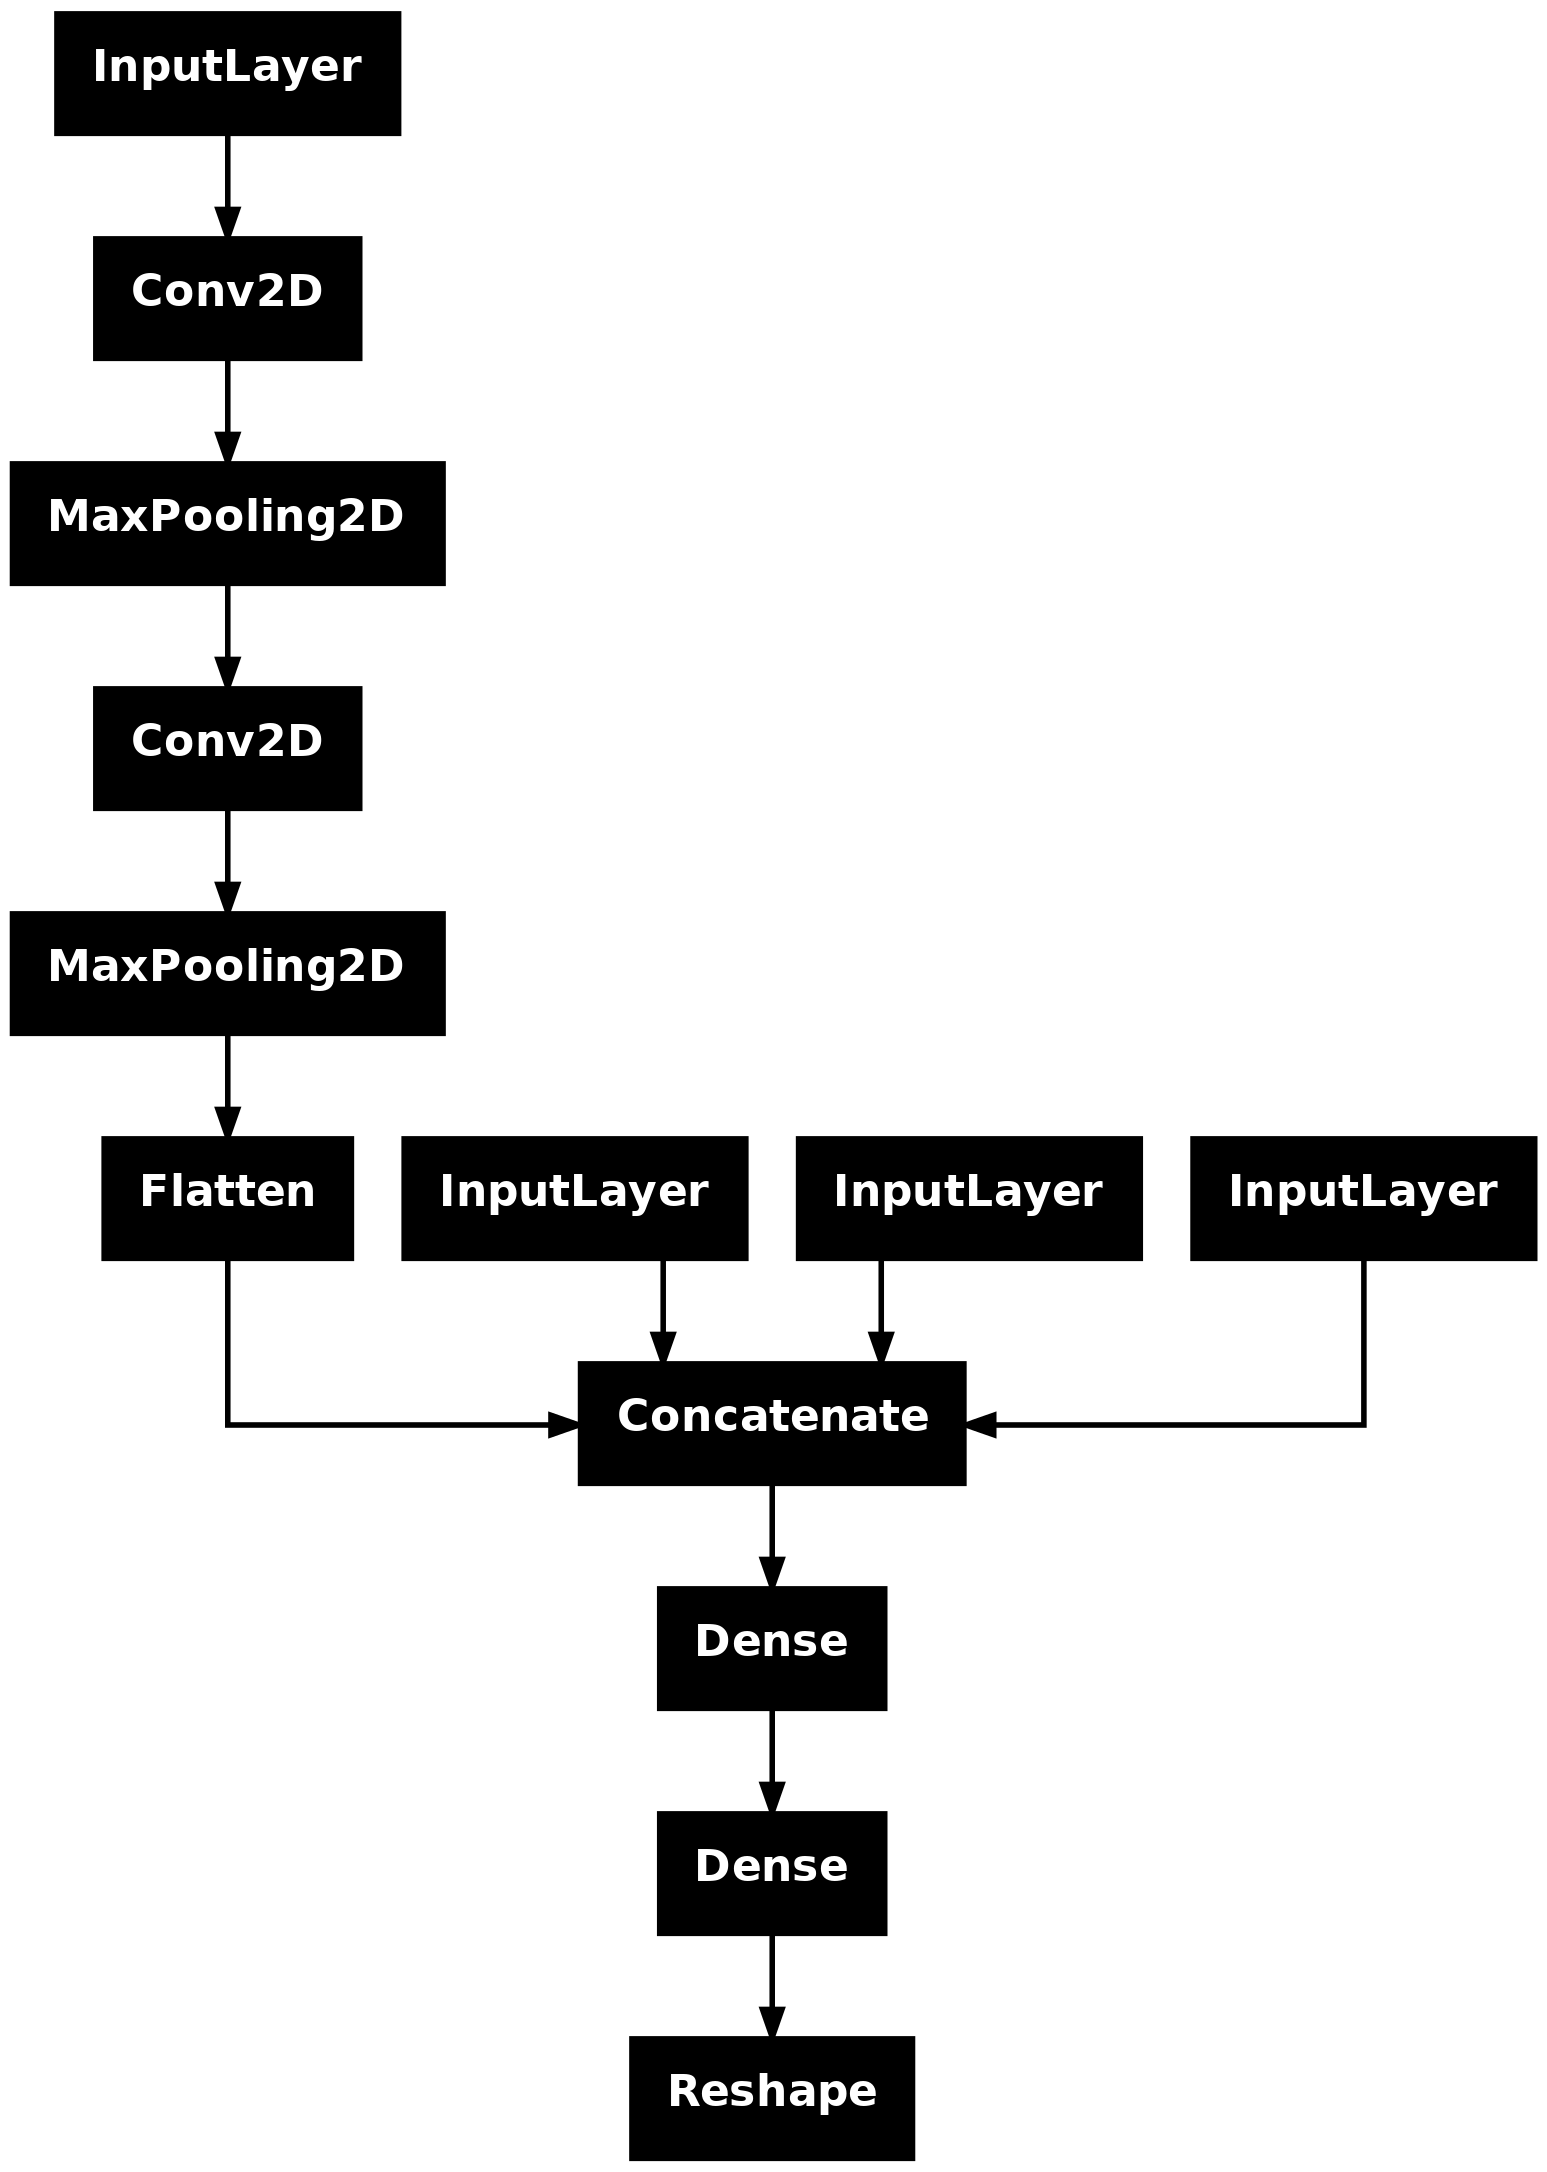

In [18]:
tf.keras.utils.plot_model(model)

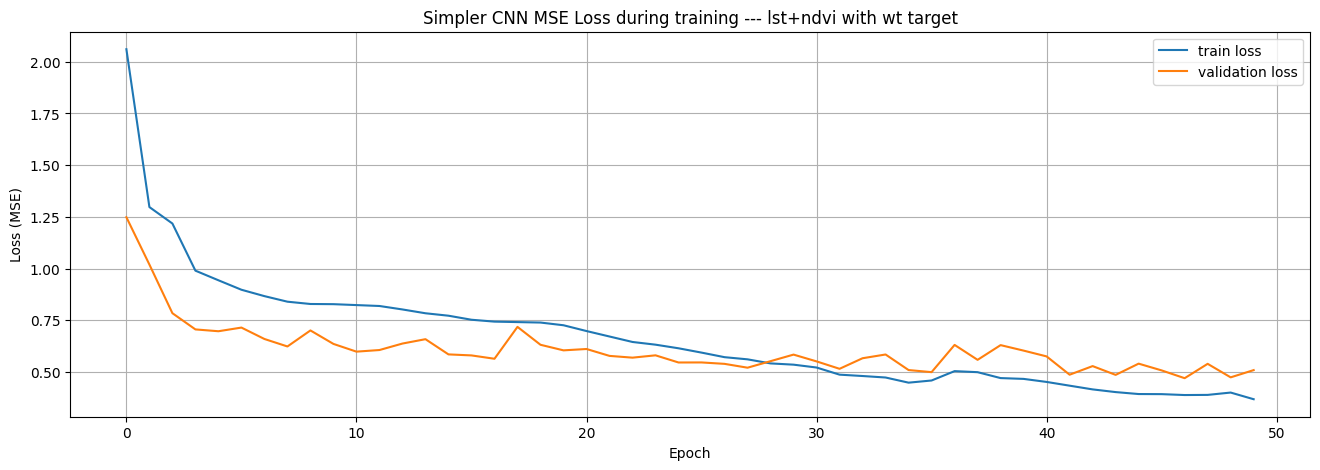

In [19]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

In [20]:
plt.savefig('../plots/cnn.png',dpi=100)

<Figure size 640x480 with 0 Axes>

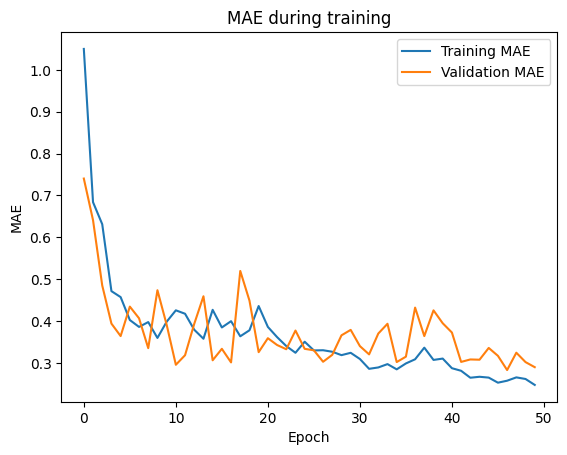

In [21]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Validate and test

Image wise metrics results

See what are the areas with more prediction error

In [22]:
if len(validation_prediction.shape) == 4:
  validation_prediction=np.squeeze(validation_prediction, axis=3)

diff = validation_prediction - validation_target
for i in range(diff.shape[0]):
  sns.heatmap(diff[i], cmap='coolwarm')
  plt.title('Prediction Error Heatmap')
  plt.show()

NameError: name 'validation_prediction' is not defined

Dispersion graph and histogram of prediction errors

In [ ]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que y_true son tus valores reales y y_pred son tus predicciones
y_true = validation_target_flat # Valores reales
y_pred = validation_prediction_flat  # Predicciones del modelo

# Visualización
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('True Values vs Predictions')
plt.show()

# Histograma de errores
errors = y_pred - y_true
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()
